In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point  # , box
import shapely.geometry
import pyproj

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# from shapely.geometry import Polygon
# import geoplot as gplt
# from sklearn.impute import SimpleImputer
# import os
# import re
# import urllib.request
# import shutil
# import zipfile
# from matplotlib import cm
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# import seaborn as sns
# import contextily as ctx

# import lightgbm as lgb
# import eli5
# from eli5.sklearn import PermutationImportance
# from lightgbm import LGBMClassifier
# from matplotlib import pyplot as plt
# from pdpbox import pdp, get_dataset, info_plots
# import shap

## Data

In [6]:
crimes_df = pd.read_csv("./base_crim08_08.csv", parse_dates=["fecha_hecho"], delimiter=";")
# Select relevant features
features = [
    "fecha_hecho",    
    "codigo_barrio",
    "year",
    "mes",
    "dia",
    "hora",
    "minuto",
    "latitud",
    "longitud",
    "conducta",
]
crimes_df = crimes_df[features]

# print('dates: ', str(crimes_df.fecha_hecho.describe()))
print("crimes_df data shape ", crimes_df.shape)

# crimes_df.to_csv('./crimes_df_features.csv', index=True)

# describe data and see if there are missing values
# print(crimes_df.describe())

# check for missing values
print("Missing values: ")
print(crimes_df.isnull().sum())

# drop missing values
print("dropping missing values")
crimes_df = crimes_df.dropna()

# save train and test data
# train.to_csv('./train.csv', index=False)
# test.to_csv('./test.csv', index=False)
print('\ncrimes dtypes: ', crimes_df.dtypes)

crimes_df data shape  (402720, 10)
Missing values: 
fecha_hecho        143
codigo_barrio      868
year               143
mes                143
dia                143
hora               143
minuto             143
latitud          27507
longitud         27507
conducta           143
dtype: int64
dropping missing values

crimes dtypes:  fecha_hecho       object
codigo_barrio     object
year             float64
mes              float64
dia              float64
hora             float64
minuto           float64
latitud          float64
longitud         float64
conducta          object
dtype: object


### SHP and intersections

xmin: 430040.7270015035 ymin: 682661.9441879238 xmax: 441947.4968490662 ymax: 697821.7320820777


C:\Users\Nicolas\AppData\Local\Temp\ipykernel_18188\2913610642.py:14: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == "Polygon":
c:\Users\Nicolas\Documents\TRABAJOS\TESIS_CAMILA\workspace_python\myvenv39\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_18188\2913610642.py:14: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == "Polygon":
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_18188\2913610642.py:14: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_typ

          fecha_hecho codigo_barrio    year  mes  dia  hora  minuto   latitud  \
0     2/01/2017 17:30         #1006  2017.0  1.0  2.0  17.0    30.0  6.251426   
2339  2/05/2003 21:30         #1019  2003.0  5.0  2.0  21.0    30.0  6.250955   
2350  2/05/2003 21:30         #1019  2003.0  5.0  2.0  21.0    30.0  6.250955   
3855  6/07/2003 20:00         #1019  2003.0  7.0  6.0  20.0     0.0  6.250235   
3859  6/07/2003 20:00         #1019  2003.0  7.0  6.0  20.0     0.0  6.250235   

       longitud        conducta                    Coordinates  grid_id  
0    -75.570280  Hurto de carro  POINT (436915.920 691032.060)     2626  
2339 -75.569166  Hurto de carro  POINT (437039.109 690979.858)     2626  
2350 -75.569166  Hurto de carro  POINT (437039.109 690979.858)     2626  
3855 -75.569480  Hurto de carro  POINT (437004.287 690900.301)     2626  
3859 -75.569480  Hurto de carro  POINT (437004.287 690900.301)     2626  

 --------------------
                                              

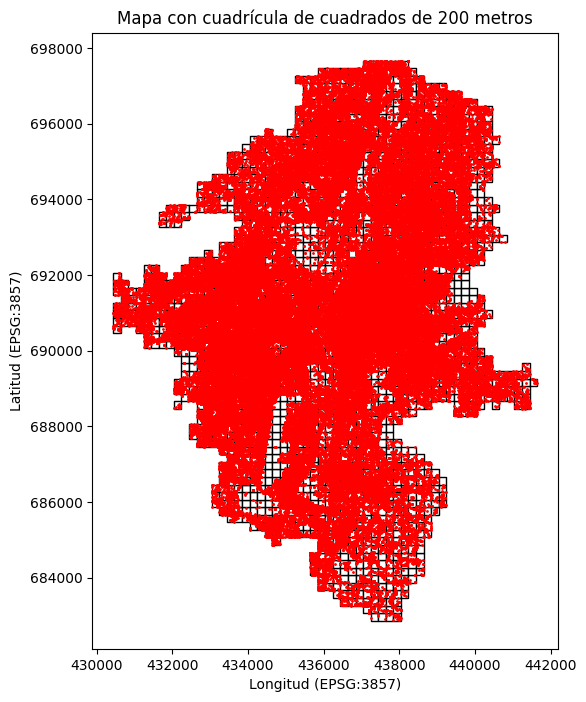

In [7]:
# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32618")
to_original_transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32618")


# Definir la función de conversión de grados a metros
def convertir_lat_long_a_metros(lat, long):
    transformed = to_proxy_transformer.transform(lat, long)
    return transformed[0], transformed[1]


# Perform spatial join by rounding coordinates for more accurate intersection
def round_coords(geom):
    if geom.type == "Polygon":
        return shapely.geometry.Polygon(
            [(round(x, 4), round(y, 4)) for x, y in geom.exterior.coords]
        )
    elif geom.type == "Point":
        return Point(round(geom.x, 4), round(geom.y, 4))
    else:
        return geom


def create_gdf(df):
    gdf = df.copy()
    gdf["Coordinates"] = list(zip(gdf.longitud, gdf.latitud))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(gdf, geometry="Coordinates", crs="epsg:32618")
    return gdf


# Leer el archivo SHP y crear un objeto GeoDataFrame
ruta_archivo_shp = "shp/BarrioVereda_2014.shp"
gdf = gpd.read_file(ruta_archivo_shp)

# Filtrar por el código de comunas de Medellín (son 16 comunas en total)
gdf = gdf[gdf["LIMITECOMU"] < "17"]

# Reproyectar a coordenadas planas
gdf = gdf.to_crs(epsg=32618)

# Crear el polígono único que representa el límite exterior de todos los polígonos
outter_map = gdf.unary_union

# Crear un nuevo GeoDataFrame con el polígono del límite exterior
gdf_outter = gpd.GeoDataFrame(geometry=[outter_map], crs=gdf.crs)

xmin, ymin, xmax, ymax = gdf_outter.total_bounds
print("xmin:", xmin, "ymin:", ymin, "xmax:", xmax, "ymax:", ymax)


stepsize = 200  # 200 meters grid step size

# Iterate over 2D area and create grid squares (boxes) with consecutive grid_id
gridboxes = []
grid_id = 1  # Initialize grid_id to start from 1
x = xmin
while x < xmax:
    y = ymin
    while y < ymax:
        box = shapely.geometry.box(x, y, x + stepsize, y + stepsize)
        box_properties = {"geometry": box, "grid_id": grid_id}
        gridboxes.append(box_properties)
        grid_id += 1  # Increment grid_id for the next box
        y += stepsize
    x += stepsize

# Create a GeoDataFrame from gridboxes
grid_gdf = gpd.GeoDataFrame(gridboxes, crs=gdf.crs)
grid_gdf["geometry"] = grid_gdf["geometry"].apply(round_coords)

# Perform spatial join
grid_outter_gdf = gpd.sjoin(grid_gdf, gdf_outter, how="inner", op="within")
grid_outter_gdf["geometry"] = grid_outter_gdf["geometry"].apply(round_coords)


# **** 2. Cargar los datos de los delitos ****
crimes_gdf = create_gdf(crimes_df)

crimes_gdf["Coordinates"] = crimes_gdf["Coordinates"].apply(round_coords)

# Convertir las coordenadas de latitud y longitud a metros y crear una nueva columna
crimes_gdf["Coordinates"] = crimes_gdf.apply(
    lambda row: Point(*convertir_lat_long_a_metros(row["latitud"], row["longitud"])),
    axis=1,
)


# eliminar todos los coordinates que tengan infinity
crimes_gdf = crimes_gdf[
    crimes_gdf["Coordinates"].apply(lambda x: not np.isinf(x.coords[0][0]))
]

# eliminar todos los registros que tengan latitud y longitud 0
crimes_gdf = crimes_gdf[
    crimes_gdf["Coordinates"].apply(
        lambda x: x.coords[0][0] != 0 and x.coords[0][1] != 0
    )
]

# eliminar todos los registros que tengan mayor a 8000000
# crimes_gdf = crimes_gdf[
#     crimes_gdf["Coordinates"].apply(lambda x: x.coords[0][0] < 8000000)
# ]

# Realizar la intersección usando gpd.sjoin()
crimes_gdf = gpd.sjoin(
    crimes_gdf, grid_outter_gdf[["grid_id", "geometry"]], how="inner", op="within"
)

# eliminar columna de index_right
crimes_gdf = crimes_gdf.drop(columns=["index_right"])

print(crimes_gdf.head())

print("\n --------------------")

print(grid_outter_gdf.head())

# Plot the map and grid squares
fig, ax = plt.subplots(figsize=(10, 8))
grid_outter_gdf.plot(ax=ax, color="white", edgecolor="black")
crimes_gdf.plot(ax=ax, color="red", markersize=1)
# gdf_outter.plot(ax=ax, color='lightgray', edgecolor='black')


plt.title("Mapa con cuadrícula de cuadrados de 200 metros")
plt.xlabel("Longitud (EPSG:3857)")
plt.ylabel("Latitud (EPSG:3857)")
plt.show()

In [8]:
# Convertir la columna conducta en una variable categorica pero ahora convirtiendo el texto a mayusculas y quitando los espacios(se reemplazan por guiones bajos ) y sin caracteres especiales
crimes_gdf["conducta"] = crimes_gdf["conducta"].str.upper()
crimes_gdf["conducta"] = crimes_gdf["conducta"].str.replace(" ", "_")
crimes_gdf["conducta"] = crimes_gdf["conducta"].str.replace("Á", "A")
crimes_gdf["conducta"] = crimes_gdf["conducta"].str.replace("É", "E")
crimes_gdf["conducta"] = crimes_gdf["conducta"].str.replace("Í", "I")
crimes_gdf["conducta"] = crimes_gdf["conducta"].str.replace("Ó", "O")
crimes_gdf["conducta"] = crimes_gdf["conducta"].str.replace("Ú", "U")
crimes_gdf["conducta"] = crimes_gdf["conducta"].str.replace("Ñ", "N")

# Description of our new dataset
crimes_gdf.head()

# write to csv file
crimes_gdf.to_csv("crimes_grids.csv", index=False, encoding='utf-8')

### Load Data

In [2]:
# cargar CSV de crimenes con join
df_crime = pd.read_csv("./crimes_grids.csv", sep=",", encoding="latin-1")

# filtrar solo los datos de anio 2008 en adelante
df_crime = df_crime[df_crime["year"] >= 2008]

# transformar variable de codigo_barrio a int, es decir modificar los registros que tengan el caracter # en la columna de codigo_barrio para dejar solo el numero
df_crime["codigo_barrio"] = df_crime["codigo_barrio"].str.replace("#", "")

# parsear el dato de codigo_barrio a int, los que no se puedan parsear a interos se eliminan esos registros del dataframe
df_crime["codigo_barrio"] = pd.to_numeric(df_crime["codigo_barrio"], errors="coerce")

df_crime.head(10)

,fecha_hecho,codigo_barrio,year,mes,dia,hora,minuto,latitud,longitud,conducta,Coordinates,grid_id
0,2/01/2017 17:30,1006.0,2017.0,1.0,2.0,17.0,30.0,6.251426,-75.570280,HURTO_DE_CARRO,POINT (436915.91970587324 691032.0601201904),2626
21,12/02/2008 13:30,1019.0,2008.0,2.0,12.0,13.0,30.0,6.250235,-75.569480,HURTO_DE_CARRO,POINT (437004.2867161578 690900.3009056267),2626
22,12/02/2008 13:30,1019.0,2008.0,2.0,12.0,13.0,30.0,6.250235,-75.569480,HURTO_DE_CARRO,POINT (437004.2867161578 690900.3009056267),2626
23,3/03/2008 15:00,1019.0,2008.0,3.0,3.0,15.0,0.0,6.250955,-75.569166,HURTO_DE_CARRO,POINT (437039.10851902544 690979.8582942786),2626
24,3/03/2008 15:00,1019.0,2008.0,3.0,3.0,15.0,0.0,6.250955,-75.569166,HURTO_DE_CARRO,POINT (437039.10851902544 690979.8582942786),2626
25,24/10/2011 9:20,1006.0,2011.0,10.0,24.0,9.0,20.0,6.251435,-75.570037,HURTO_DE_CARRO,POINT (436942.81324832625 691033.0259159068),2626
26,14/06/2012 16:00,1019.0,2012.0,6.0,14.0,16.0,0.0,6.250235,-75.569480,HURTO_DE_CARRO,POINT (437004.2867161578 690900.3009056267),2626
27,2/03/2013 17:00,1006.0,2013.0,3.0,2.0,17.0,0.0,6.251679,-75.570552,HURTO_DE_CARRO,POINT (436885.8716254722 691060.0615235303),2626
28,2/03/2013 16:40,1006.0,2013.0,3.0,2.0,16.0,40.0,6.251679,-75.570552,HURTO_DE_CARRO,POINT (436885.8716254722 691060.0615235303),2626
29,19/01/2016 19:00,1019.0,2016.0,1.0,19.0,19.0,0.0,6.250517,-75.569979,HURTO_DE_CARRO,POINT (436949.08852897753 690931.5785139108),2626


In [4]:
# temp df cod_barrio e grid_id uniques
df_cod_barrio = df_crime[['codigo_barrio', 'grid_id']].drop_duplicates()

df_cod_barrio.head(20)

,codigo_barrio,grid_id
0,1006.0,2626
21,1019.0,2626
2485,519.0,2259
2497,707.0,2259
2646,702.0,2259
2831,710.0,2264
2862,709.0,2264
2882,514.0,2264
2935,809.0,3384
2951,808.0,3384


In [4]:
# Agrupar los datos
df_crime = df_crime.groupby(["grid_id", "fecha_hecho", "conducta"]).size()

# Llenar a lo largo de todas las dimensiones: los datos faltantes significan que no hay incidentes criminales, se requieren algunas operaciones de apilamiento
df_crime = (
    df_crime.unstack(["grid_id", "conducta"])
    .asfreq("D", fill_value=0)
    .stack(["grid_id", "conducta"])
    .reset_index(name="crime_count")
)

# Crear un DataFrame a partir de la Serie
df_crime = pd.DataFrame(df_crime)

MemoryError: Unable to allocate 22.0 MiB for an array with shape (536, 5369) and data type float64

In [12]:
df_crime.head(10)

,fecha_hecho,grid_id,conducta,crime_count
0,2003-01-01,192,EXTORSION,0.0
1,2003-01-01,192,HOMICIDIO,0.0
2,2003-01-01,192,HURTO_A_PERSONA,0.0
3,2003-01-01,192,HURTO_A_RESIDENCIA,0.0
4,2003-01-01,192,HURTO_DE_CARRO,0.0
5,2003-01-01,193,EXTORSION,0.0
6,2003-01-01,193,HOMICIDIO,0.0
7,2003-01-01,193,HURTO_A_PERSONA,0.0
8,2003-01-01,193,HURTO_A_RESIDENCIA,0.0
9,2003-01-01,194,EXTORSION,0.0


In [13]:
# Description of our new dataset 
df_crime.describe()

,fecha_hecho,grid_id,crime_count
count,68244575,6.824458e+07,68244575.0
mean,2012-11-06 00:00:00.000001280,2.389253e+03,0.0
min,2003-01-01 00:00:00,1.920000e+02,0.0
25%,2007-12-04 00:00:00,1.707000e+03,0.0
50%,2012-11-06 00:00:00,2.449000e+03,0.0
75%,2017-10-10 00:00:00,3.080000e+03,0.0
max,2022-09-12 00:00:00,4.365000e+03,0.0
std,NaN,8.802317e+02,0.0


### Merge features

In [14]:
# Cargar datos de caracteristicas de los crimenes de archivo xlsx
characteristics = pd.read_excel("./characteristics.xlsx")

# eliminaar registros que tengan CODIGO null nan o con un caracter '.'
characteristics = characteristics[characteristics["CODIGO"].notna()]
characteristics = characteristics[characteristics["CODIGO"] != "."]

# convertir a entero el codigo
characteristics["CODIGO"] = characteristics["CODIGO"].astype(int)

# renombrar columna de characteristics "CODIGO" a "codigo_barrio"
characteristics = characteristics.rename(columns={"CODIGO": "codigo_barrio"})


KeyError: 'codigo_barrio'

In [ ]:
# describir caracteristicas de los datos
characteristics.head(10)

print('\nCharacteristics dtypes: ', characteristics.dtypes)

print('\ncharacteristics describe: ', characteristics.describe())

# print(df_crime.describe())

### Merge data

In [ ]:
# merge characteristics and df_crime to get the final dataset for prediction
df_crime = df_crime.merge(characteristics, how='inner', on='codigo_barrio')

df_crime.head()

In [ ]:
print(df_crime.shape)


print(df_crime.isnull().sum())

In [ ]:
print(df_crime.columns)

### Construct feature matrix

In [ ]:
#write crime_data_grd to csv
df_crime.to_csv('crime_data__grd_group.csv', index=False)

In [ ]:
#Instances of crime_count per date, neighborhood, and crime category
cc = df_crime.groupby('conducta').size()
fig, axes = plt.subplots(1, 2, figsize=(14, 4));
cc.plot.bar(logy=False, ax=axes[0], title='Instances of crime_count, lin axes');
cc.plot.bar(logy=True, ax=axes[1], title='Instances of crime_count, log-lin axes');

In [ ]:
# split data into train and test
train, test = train_test_split(crimes_df, test_size=0.2, random_state=42)

print("train data shape ", train.shape)
print("test data shape ", test.shape)